
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


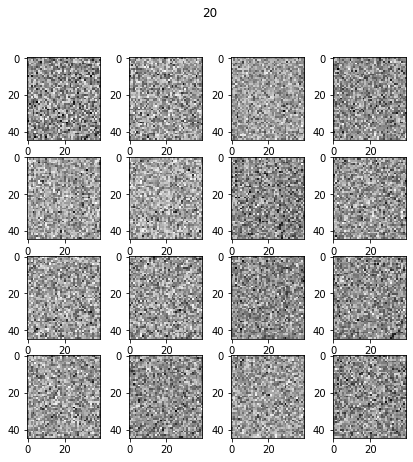

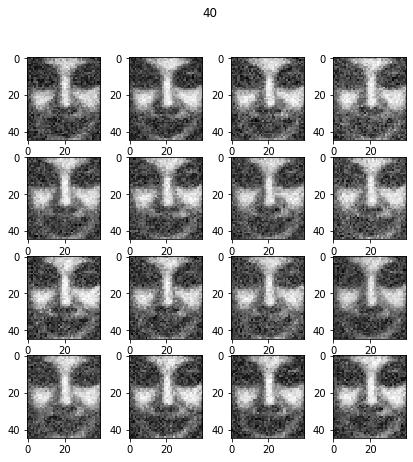

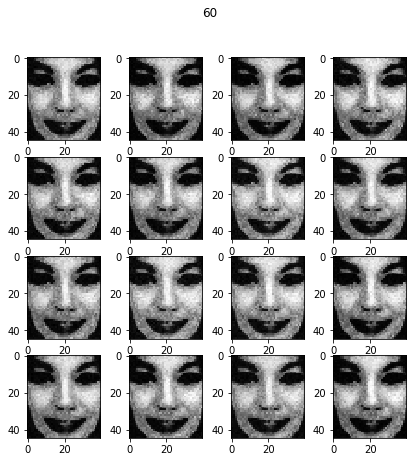

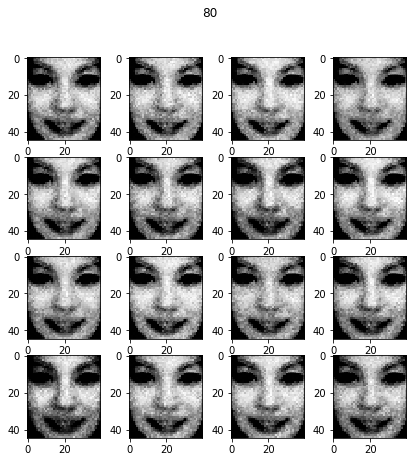

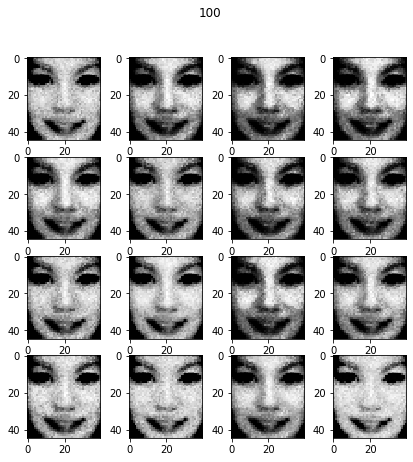

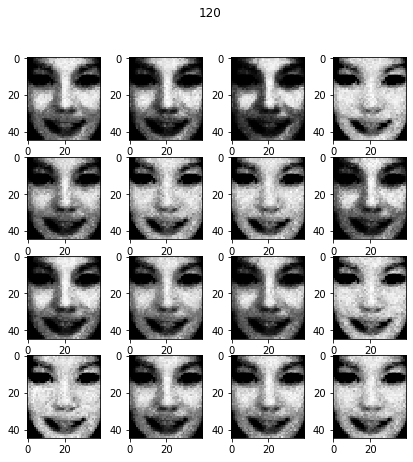

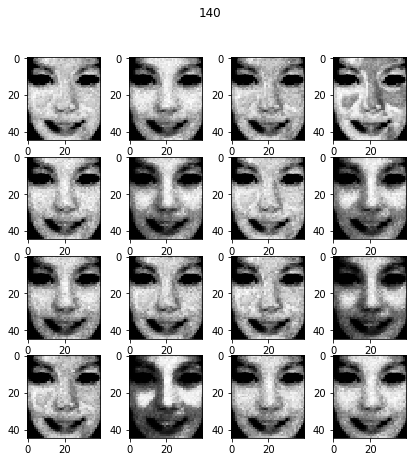

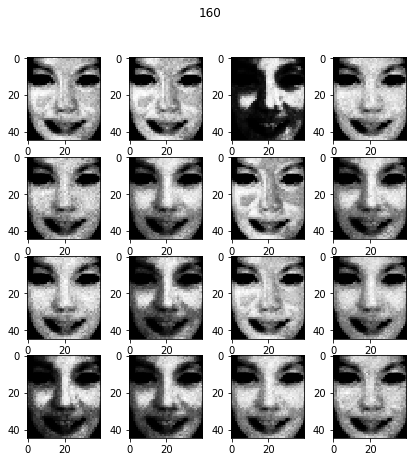

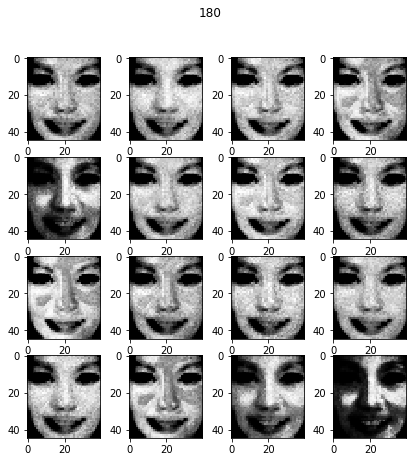

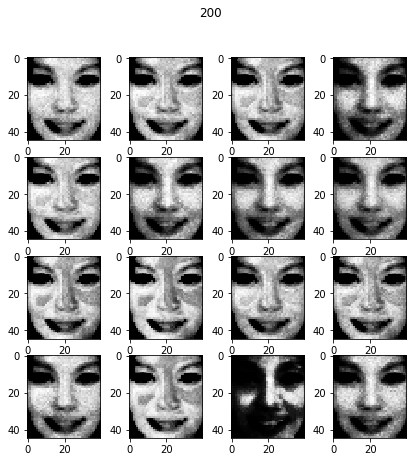

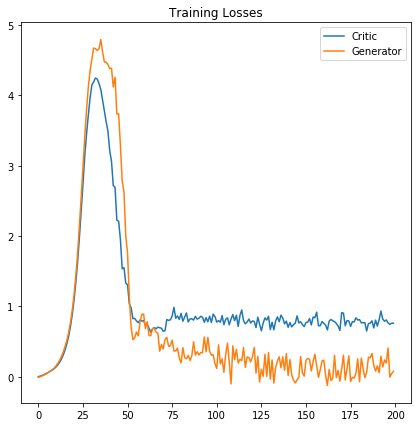

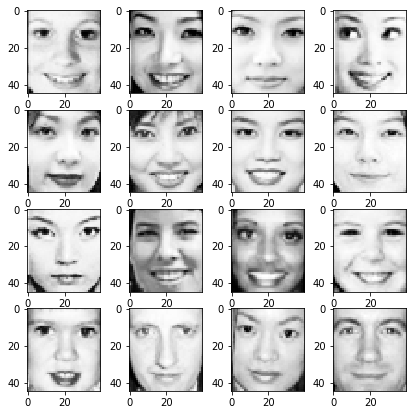

In [1]:
# 필요한 라이브러리 불러들임 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image as Im
import glob   
import os
%matplotlib inline

# 그래프 리셋
tf.reset_default_graph() 
# 재현성을 위해 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
files=glob.glob('./face20/*.png')
img=[]        
for file in files:
    temp=Im.open(file); 
    temp=temp.convert('L') # 계산 시간 절약 위해 흑백으로 
    temp=np.array(temp)
    img.append(temp)        


# 리스트를 array로
x=np.asarray(img)/255. 
n_cell=np.prod(x.shape[1:3]) # 45*40=1800
# 이미지를 벡터로 =[20,1800]
Ximg=np.reshape(x,[len(img),n_cell]) #=[20,1800]

# 관측치 수 (=20)
sample_size=Ximg.shape[0] #=20
# 입력 변수 수 (=1800)
input_dim = Ximg.shape[1] #=1800

    
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 50
# 생성자의 두 은닉층 크기: 128
# 비판자의 두 은닉층 크기: 128
# 미니배치 크기: 10
# 반복 수: 200
# 학습률 : 0.01
# 클립핑 값 : 0.01
learning_rate = 0.001 #학습률 
batch_size = 5 # 배치크기
z_size = 50 #잡음 크기
nepochs = 200 # 반복 수 
g_hidden_size = 128 # 생성자 은닉층 크기
d_hidden_size = 128 # 판별자  은닉층 크기
clip=0.01
alpha=0.1# for leaky Relu, alpha=0 --> ReLu

# 진짜데이터 placeholder 
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
# 집음 placeholder
Z = tf.placeholder(tf.float32, shape=[None, z_size], name='Z')

# 비판자의 가중치와 편의 정의(# 사비에르 초기치 사용)
D_W1 = tf.get_variable('D_W1',shape=[input_dim,d_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer=tf.contrib.layers.xavier_initializer())
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]


# 생성망의 가중치와 편의 정의(# 사비에르 초기치 사용)
G_W1 = tf.get_variable('G_W1',shape=[z_size,g_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')
G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,input_dim],initializer=tf.contrib.layers.xavier_initializer())
G_b2 = tf.Variable(tf.zeros(shape=[input_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]

#------------------------------------------------
# 생성자 정의: 입력된 진짜 이미지와 유사한 가짜 이미지 생성
#------------------------------------------------
def generator(z):
        h1=tf.matmul(z, G_W1) + G_b1        
        h1 = tf.maximum(alpha*h1, h1) 
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.sigmoid(h2)  
        return out


#------------------------------------------------
# 비판자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
def critic(x):
        h1=tf.matmul(x, D_W1) + D_b1        
        h1 = tf.maximum(alpha*h1, h1)    
        h2 = tf.matmul(h1, D_W2) + D_b2
        #prob = tf.nn.sigmoid(h2)
        return h2

# 가짜데이터
G = generator(Z)

# 진짜 데이터의 비판자 결과 
D_logit_real = critic(X)
D_logit_fake = critic(G)

#비용함수
D_loss = tf.reduce_mean(D_logit_real) - tf.reduce_mean(D_logit_fake)
G_loss = -tf.reduce_mean(D_logit_fake)

# Optimizer 
D_solver = tf.train.RMSPropOptimizer(learning_rate).minimize(-D_loss, var_list=theta_D)
G_solver = tf.train.RMSPropOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)

# 클립핑을 통해 1-Lipshitz 조건 충족
clip_D = [p.assign(tf.clip_by_value(p, -clip, clip)) for p in theta_D]

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
sess=tf.Session(); 
sess.run(tf.global_variables_initializer())
samples = []
losses = []

for epoch in range(nepochs):
    n_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(n_batch):
        if ii!=n_batch:
              batch_images=Ximg[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_images=Ximg[(ii+1)*batch_size:]           
        batch_images = batch_images*2 - 1   
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size)) 
        D_loss_curr,_ ,clipD=sess.run([D_loss,D_solver,clip_D], feed_dict={X: batch_images, Z: batch_z})
        G_loss_curr,_=sess.run([G_loss,G_solver], feed_dict={X: batch_images, Z: batch_z})               
        losss=D_loss_curr+G_loss_curr
        avg_loss+=losss/n_batch
   # print('Epoch: {0}, Discriminator Loss: {1:7.4f}, Generator Loss: {2:7.4f}'  .format(epoch+1,D_loss_curr, G_loss_curr))
    losses.append((D_loss_curr, G_loss_curr,avg_loss))        
    # 20 에폭마다 가짜 이미지 그림   
    if (epoch+1)%20==0:
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(16,z_size))
        gen_samples = sess.run(G,feed_dict={Z: sample_z})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((45,40)), cmap='Greys_r')

# 비판자, 생성자의 비용함수 그림 
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Critic')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

   
# 진짜데이터 그림   
f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(Ximg[ii].reshape(45,40),cmap='Greys_r')    